In [1]:
library(data.table)
library(dplyr)
library(Matrix)
library(BuenColors)
library(stringr)
library(cowplot)
library(ggpubr)
library(umap)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: magrittr

Attaching package: ‘ggpubr’

The following object is masked from ‘package:cowplot’:

    get_legend



#### define functions

In [2]:
read_FM <- function(filename){
    df_FM = data.frame(readRDS(filename),stringsAsFactors=FALSE,check.names=FALSE)
    rownames(df_FM) <- make.names(rownames(df_FM), unique=TRUE)
    df_FM[is.na(df_FM)] <- 0
    return(df_FM)
}

run_pca <- function(mat,num_pcs=50,remove_first_PC=FALSE,scale=FALSE,center=FALSE){
    set.seed(2019) 
    mat = as.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    sk_diag = matrix(0, nrow=num_pcs, ncol=num_pcs)
    diag(sk_diag) = SVD$d
    if(remove_first_PC){
        sk_diag[1,1] = 0
        SVD_vd = (sk_diag %*% t(SVD$v))[2:num_pcs,]
    }else{
        SVD_vd = sk_diag %*% t(SVD$v)
    }
    return(SVD_vd)
}

elbow_plot <- function(mat,num_pcs=50,scale=FALSE,center=FALSE,title='',width=3,height=3){
    set.seed(2019) 
    mat = data.matrix(mat)
    SVD = irlba(mat, num_pcs, num_pcs,scale=scale,center=center)
    options(repr.plot.width=width, repr.plot.height=height)
    df_plot = data.frame(PC=1:num_pcs, SD=SVD$d);
#     print(SVD$d[1:num_pcs])
    p <- ggplot(df_plot, aes(x = PC, y = SD)) +
      geom_point(col="#cd5c5c",size = 1) + 
      ggtitle(title)
    return(p)
}

run_umap <- function(fm_mat){
    umap_object = umap(t(fm_mat),random_state = 2019)
    df_umap = umap_object$layout
    return(df_umap)
}


plot_umap <- function(df_umap,labels,title='UMAP',colormap=colormap){
    set.seed(2019) 
    df_umap = data.frame(cbind(df_umap,labels),stringsAsFactors = FALSE)
    colnames(df_umap) = c('umap1','umap2','label')
    df_umap$umap1 = as.numeric(df_umap$umap1)
    df_umap$umap2 = as.numeric(df_umap$umap2)
    options(repr.plot.width=4, repr.plot.height=4)
    p <- ggplot(shuf(df_umap), aes(x = umap1, y = umap2, color = label)) +
      geom_point(size = 1) + scale_color_manual(values = colormap) +
      ggtitle(title)
    return(p)
}

### Input

In [3]:
workdir = './output_new/'

path_umap = paste0(workdir,'umap_rds/')
system(paste0('mkdir -p ',path_umap))

path_fm = paste0(workdir,'feature_matrices/')
system(paste0('mkdir -p ',path_fm))

In [4]:
metadata <- read.table('../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

In [5]:
path_fm_old = './output/feature_matrices/'
path_umap_old = './output/umap_rds/'

In [6]:
list.files(path_fm_old,pattern="^FM*")

[1] "FM_BROCKMAN_buenrostro2018.rds"           
 [2] "FM_chromVAR_buenrostro2018_kmers_pca.rds" 
 [3] "FM_chromVAR_buenrostro2018_kmers.rds"     
 [4] "FM_chromVAR_buenrostro2018_motifs_pca.rds"
 [5] "FM_chromVAR_buenrostro2018_motifs.rds"    
 [6] "FM_Cicero_buenrostro2018_pca.rds"         
 [7] "FM_Cicero_buenrostro2018.rds"             
 [8] "FM_cisTopic_buenrostro2018.rds"           
 [9] "FM_Control_buenrostro2018.rds"            
[10] "FM_Cusanovich2018_buenrostro2018.rds"     
[11] "FM_GeneScoring_buenrostro2018_pca.rds"    
[12] "FM_GeneScoring_buenrostro2018.rds"        
[13] "FM_scABC_buenrostro2018.rds"              
[14] "FM_Scasat_buenrostro2018.rds"             
[15] "FM_SCRAT_buenrostro2018_motifs.rds"       
[16] "FM_SCRAT_buenrostro2018_pca.rds"          
[17] "FM_SnapATAC_buenrostro2018.rds"

In [7]:
list.files(path_umap_old,pattern="^df*")

[1] "df_umap_BROCKMAN.rds"         "df_umap_chromVAR_kmers.rds"  
 [3] "df_umap_chromVAR_kmers2.rds"  "df_umap_chromVAR_motifs.rds" 
 [5] "df_umap_chromVAR_motifs2.rds" "df_umap_Cicero.rds"          
 [7] "df_umap_Cicero2.rds"          "df_umap_cisTopic.rds"        
 [9] "df_umap_Control.rds"          "df_umap_Cusanovich2018.rds"  
[11] "df_umap_GeneScoring.rds"      "df_umap_GeneScoring2.rds"    
[13] "df_umap_scABC.rds"            "df_umap_Scasat.rds"          
[15] "df_umap_SCRAT.rds"            "df_umap_SCRAT2.rds"          
[17] "df_umap_SnapATAC.rds"

In [8]:
for (filename in list.files(path_fm_old,pattern="^FM*")){
    filename_split = unlist(strsplit(sub('\\.rds$', '', filename),'_'))
    filename_split = filename_split[-3]
    method_i = filename_split[2]
    if(filename_split[length(filename_split)]=='pca'){
        method_i = paste(filename_split[2:(length(filename_split)-1)],collapse = '_')
        method_i = paste0(method_i,'2')
    }else{
        method_i = paste(filename_split[2:length(filename_split)],collapse = '_')
    }
    print(paste0('Read in ','fm_',method_i))
    assign(paste0('fm_',method_i),read_FM(paste0(path_fm_old,filename)))
}

[1] "Read in fm_BROCKMAN"
[1] "Read in fm_chromVAR_kmers2"
[1] "Read in fm_chromVAR_kmers"
[1] "Read in fm_chromVAR_motifs2"
[1] "Read in fm_chromVAR_motifs"
[1] "Read in fm_Cicero2"
[1] "Read in fm_Cicero"
[1] "Read in fm_cisTopic"
[1] "Read in fm_Control"
[1] "Read in fm_Cusanovich2018"
[1] "Read in fm_GeneScoring2"
[1] "Read in fm_GeneScoring"
[1] "Read in fm_scABC"
[1] "Read in fm_Scasat"
[1] "Read in fm_SCRAT_motifs"
[1] "Read in fm_SCRAT2"
[1] "Read in fm_SnapATAC"


In [9]:
sapply(strsplit(list.files(path_umap_old), "\\."),'[',1)

[1] "df_umap_BROCKMAN"         "df_umap_chromVAR_kmers"  
 [3] "df_umap_chromVAR_kmers2"  "df_umap_chromVAR_motifs" 
 [5] "df_umap_chromVAR_motifs2" "df_umap_Cicero"          
 [7] "df_umap_Cicero2"          "df_umap_cisTopic"        
 [9] "df_umap_Control"          "df_umap_Cusanovich2018"  
[11] "df_umap_GeneScoring"      "df_umap_GeneScoring2"    
[13] "df_umap_scABC"            "df_umap_Scasat"          
[15] "df_umap_SCRAT"            "df_umap_SCRAT2"          
[17] "df_umap_SnapATAC"

In [10]:
for (df in sapply(strsplit(list.files(path_umap_old), "\\."),'[',1)){
  assign(df,readRDS(paste0(path_umap_old,df,'.rds')))
}

In [11]:
ls()

[1] "df"                       "df_umap_BROCKMAN"        
 [3] "df_umap_chromVAR_kmers"   "df_umap_chromVAR_kmers2" 
 [5] "df_umap_chromVAR_motifs"  "df_umap_chromVAR_motifs2"
 [7] "df_umap_Cicero"           "df_umap_Cicero2"         
 [9] "df_umap_cisTopic"         "df_umap_Control"         
[11] "df_umap_Cusanovich2018"   "df_umap_GeneScoring"     
[13] "df_umap_GeneScoring2"     "df_umap_scABC"           
[15] "df_umap_Scasat"           "df_umap_SCRAT"           
[17] "df_umap_SCRAT2"           "df_umap_SnapATAC"        
[19] "elbow_plot"               "filename"                
[21] "filename_split"           "fm_BROCKMAN"             
[23] "fm_chromVAR_kmers"        "fm_chromVAR_kmers2"      
[25] "fm_chromVAR_motifs"       "fm_chromVAR_motifs2"     
[27] "fm_Cicero"                "fm_Cicero2"              
[29] "fm_cisTopic"              "fm_Control"              
[31] "fm_Cusanovich2018"        "fm_GeneScoring"          
[33] "fm_GeneScoring2"          "fm_scABC"                
[35] "fm_Scasat"                "fm_SCRAT_motifs"         
[37] "fm_SCRAT2"                "fm_SnapATAC"             
[39] "metadata"                 "method_i"                
[41] "path_fm"                  "path_fm_old"             
[43] "path_umap"                "path_umap_old"           
[45] "plot_umap"                "read_FM"                 
[47] "run_pca"                  "run_umap"                
[49] "workdir"

In [12]:
labels = metadata$label
colormap = c(jdb_color_maps, "UNK" = "#333333" )

#### Control

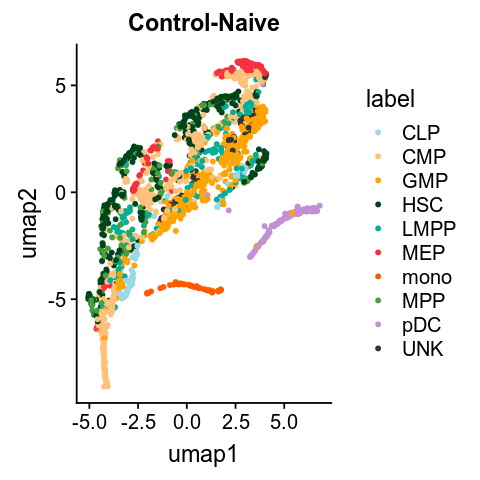

In [13]:
p_Control <- plot_umap(df_umap_Control,labels = labels,colormap = colormap,title='Control-Naive')
p_Control

In [14]:
dim(fm_Control)

[1]   50 2034

In [15]:
fm_Control_new = fm_Control[2:dim(fm_Control)[1],]
dim(fm_Control_new)

[1]   49 2034

In [16]:
df_umap_Control_new <- run_umap(fm_Control_new)

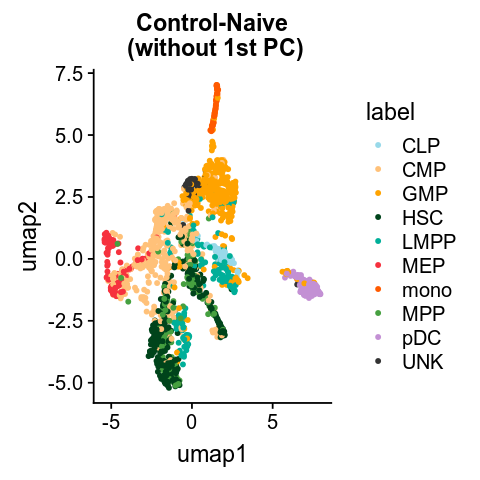

In [17]:
p_Control_new <- plot_umap(df_umap_Control_new,labels = labels,colormap = colormap,title='Control-Naive\n (without 1st PC)')
p_Control_new

#### chromVAR

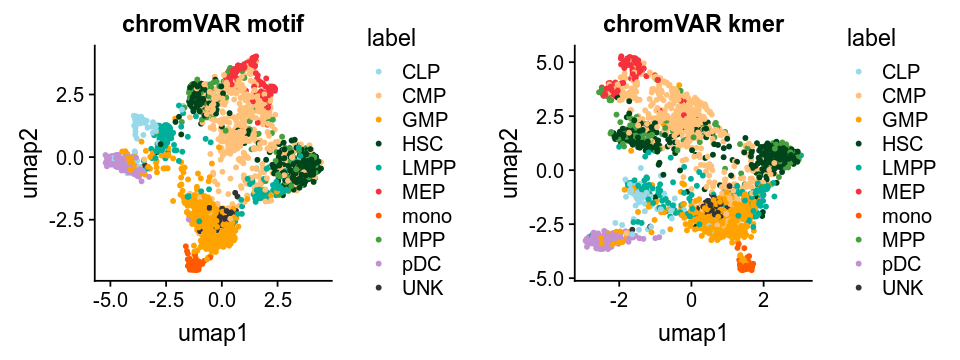

In [18]:
p_chromVAR_motifs <- plot_umap(df_umap_chromVAR_motifs,labels = labels,colormap = colormap,title='chromVAR motif')
p_chromVAR_kmers <- plot_umap(df_umap_chromVAR_kmers,labels = labels,colormap = colormap,title='chromVAR kmer')

options(repr.plot.width=8, repr.plot.height=3)
cowplot::plot_grid(p_chromVAR_motifs,p_chromVAR_kmers)

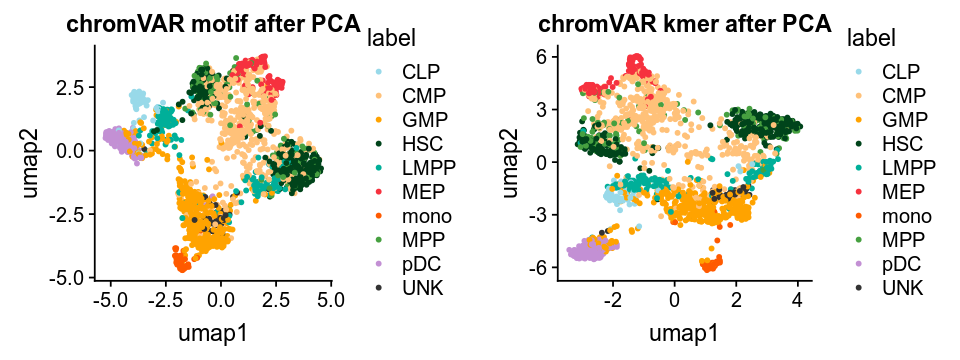

In [19]:
p_chromVAR_motifs2 <- plot_umap(df_umap_chromVAR_motifs2,labels = labels,colormap = colormap,title='chromVAR motif after PCA')
p_chromVAR_kmers2 <- plot_umap(df_umap_chromVAR_kmers2,labels = labels,colormap = colormap,title='chromVAR kmer after PCA')

options(repr.plot.width=8, repr.plot.height=3)
cowplot::plot_grid(p_chromVAR_motifs2,p_chromVAR_kmers2)

In [20]:
dim(fm_chromVAR_kmers2)
dim(fm_chromVAR_motifs2)

[1]  100 2034

[1]  100 2034

In [21]:
fm_chromVAR_kmers2_new = fm_chromVAR_kmers2[2:dim(fm_chromVAR_kmers2)[1],]
dim(fm_chromVAR_kmers2_new)
fm_chromVAR_motifs2_new = fm_chromVAR_motifs2[2:dim(fm_chromVAR_motifs2)[1],]
dim(fm_chromVAR_motifs2_new)

[1]   99 2034

[1]   99 2034

In [22]:
df_umap_chromVAR_kmers2_new <- run_umap(fm_chromVAR_kmers2_new)
df_umap_chromVAR_motifs2_new <- run_umap(fm_chromVAR_motifs2_new)

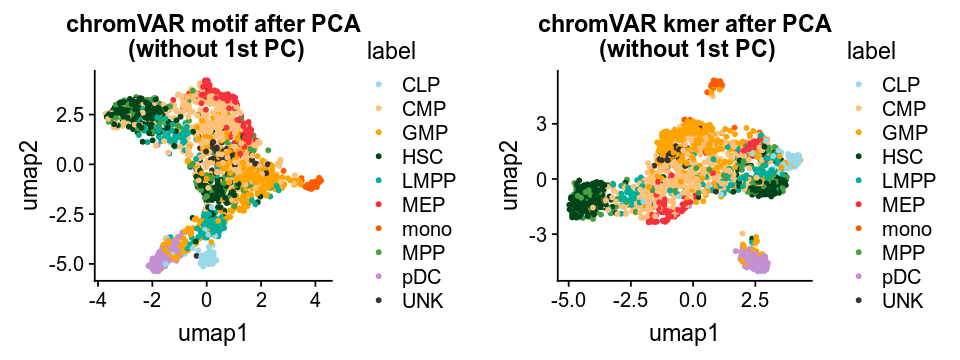

In [23]:
p_chromVAR_motifs2_new <- plot_umap(df_umap_chromVAR_motifs2_new,labels = labels,colormap = colormap,
                                    title='chromVAR motif after PCA\n (without 1st PC)')
p_chromVAR_kmers2_new <- plot_umap(df_umap_chromVAR_kmers2_new,labels = labels,colormap = colormap,
                                   title='chromVAR kmer after PCA\n (without 1st PC)')

options(repr.plot.width=8, repr.plot.height=3)
cowplot::plot_grid(p_chromVAR_motifs2_new,p_chromVAR_kmers2_new)

### Cusanovich2018

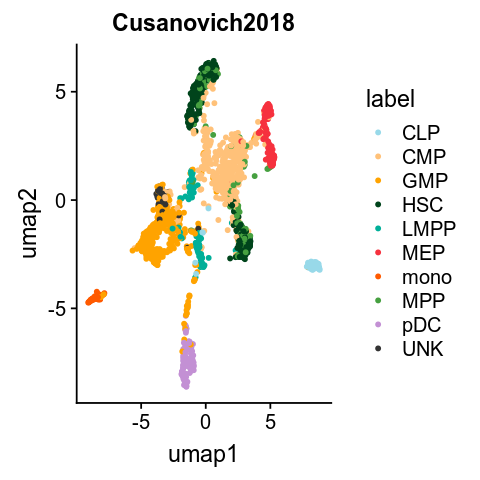

In [24]:
p_Cusanovich2018 <- plot_umap(df_umap_Cusanovich2018,labels = labels,colormap = colormap,title='Cusanovich2018')
p_Cusanovich2018

In [25]:
dim(fm_Cusanovich2018)

[1]  150 2034

In [26]:
fm_Cusanovich2018_new = fm_Cusanovich2018[2:dim(fm_Cusanovich2018)[1],]
dim(fm_Cusanovich2018_new)

[1]  149 2034

In [27]:
df_umap_Cusanovich2018_new <- run_umap(fm_Cusanovich2018_new)

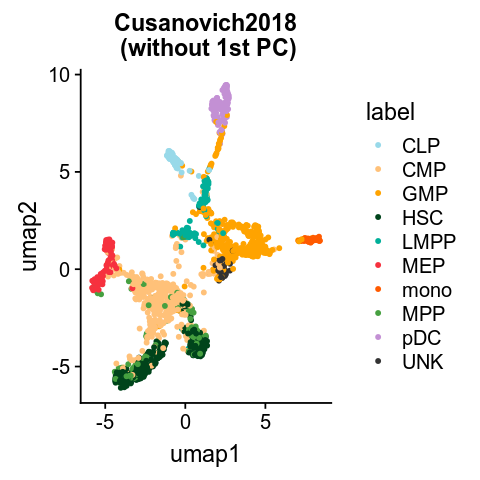

In [28]:
p_Cusanovich2018_new <- plot_umap(df_umap_Cusanovich2018_new,labels = labels,colormap = colormap,
                                  title='Cusanovich2018\n (without 1st PC)')
p_Cusanovich2018_new

### Gene Scoring

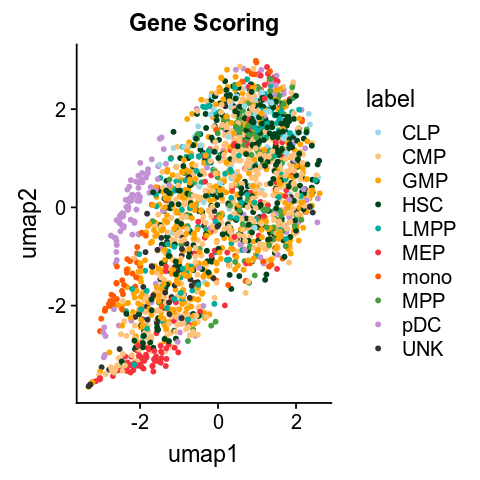

In [29]:
p_GeneScoring <- plot_umap(df_umap_GeneScoring,labels = labels,colormap = colormap,title='Gene Scoring')
p_GeneScoring

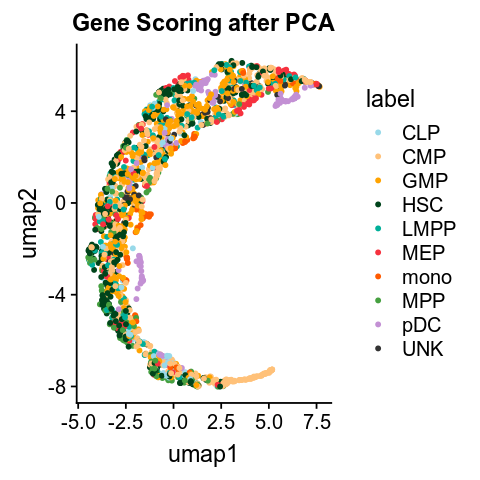

In [30]:
p_GeneScoring2 <- plot_umap(df_umap_GeneScoring2,labels = labels,colormap = colormap,title='Gene Scoring after PCA')
p_GeneScoring2

In [31]:
dim(fm_GeneScoring2)

[1]   10 2034

In [32]:
fm_GeneScoring2_new = fm_GeneScoring2[2:dim(fm_GeneScoring2)[1],]
dim(fm_GeneScoring2_new)

[1]    9 2034

In [33]:
df_umap_GeneScoring2_new <- run_umap(fm_GeneScoring2_new)

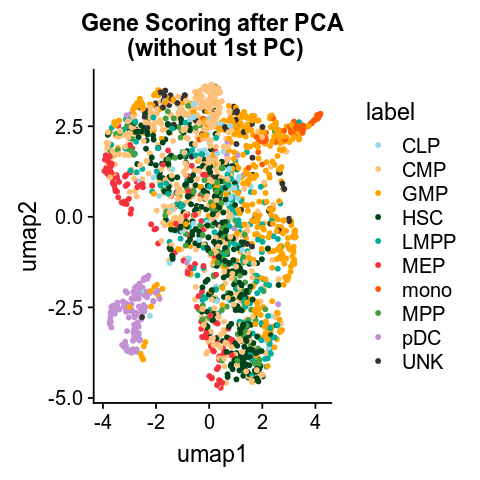

In [34]:
p_GeneScoring2_new <- plot_umap(df_umap_GeneScoring2_new,labels = labels,colormap = colormap,
                                title='Gene Scoring after PCA\n (without 1st PC)')
p_GeneScoring2_new

### Cicero

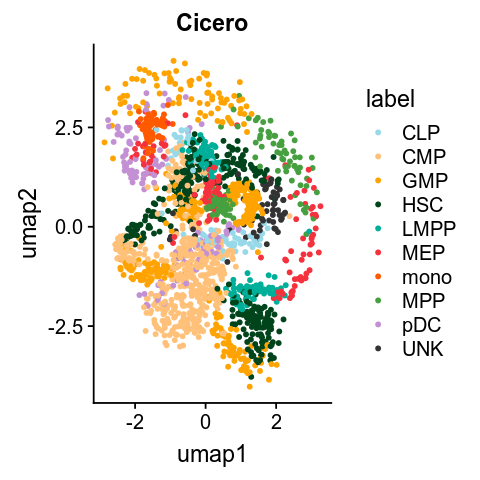

In [35]:
p_Cicero <- plot_umap(df_umap_Cicero,labels = labels,colormap = colormap,title='Cicero')
p_Cicero

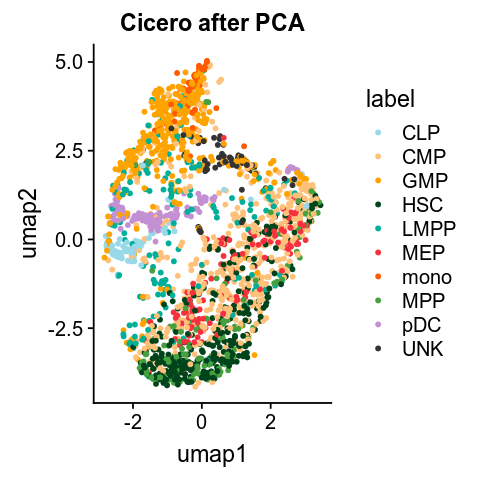

In [36]:
p_Cicero2 <- plot_umap(df_umap_Cicero2,labels = labels,colormap = colormap,title='Cicero after PCA')
p_Cicero2

In [37]:
dim(fm_Cicero2)

[1]  100 2034

In [38]:
fm_Cicero2_new = fm_Cicero2[2:dim(fm_Cicero2)[1],]
dim(fm_Cicero2_new)

[1]   99 2034

In [39]:
df_umap_Cicero2_new <- run_umap(fm_Cicero2_new)

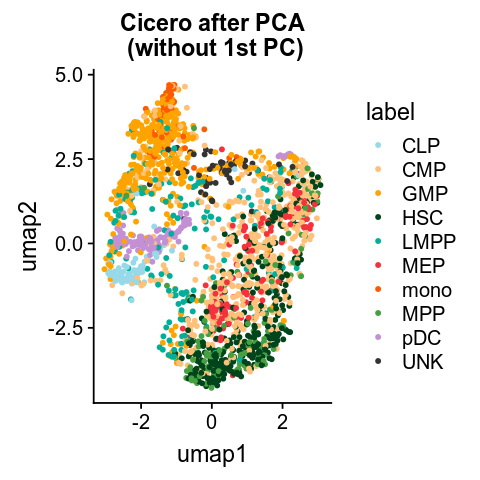

In [40]:
p_Cicero2_new <- plot_umap(df_umap_Cicero2_new,labels = labels,colormap = colormap,
                           title='Cicero after PCA\n (without 1st PC)')
p_Cicero2_new

### SnapATAC

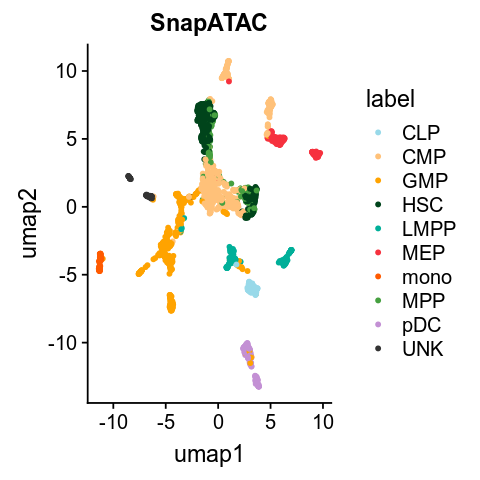

In [41]:
p_SnapATAC <- plot_umap(df_umap_SnapATAC,labels = labels,colormap = colormap,title='SnapATAC')
p_SnapATAC

In [42]:
dim(fm_SnapATAC)

[1]   20 2034

In [43]:
fm_SnapATAC_new = fm_SnapATAC[2:dim(fm_SnapATAC)[1],]
dim(fm_SnapATAC_new)

[1]   19 2034

In [44]:
df_umap_SnapATAC_new <- run_umap(fm_SnapATAC_new)

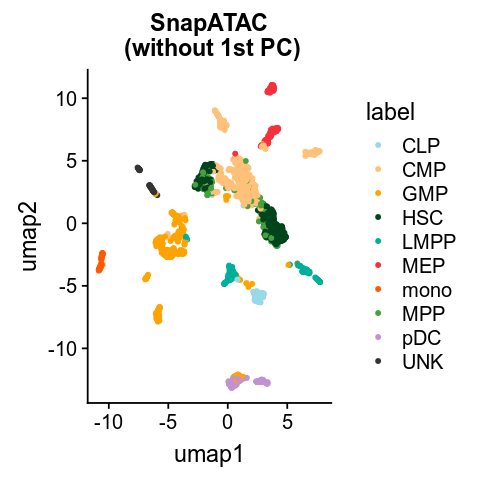

In [45]:
p_SnapATAC_new <- plot_umap(df_umap_SnapATAC_new,labels = labels,colormap = colormap,title='SnapATAC\n (without 1st PC)')
p_SnapATAC_new

### SCRAT

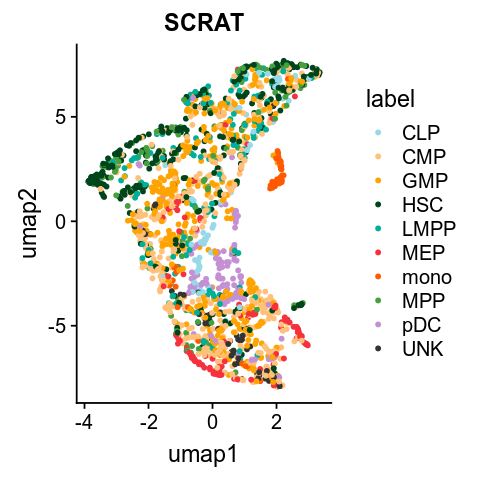

In [46]:
p_SCRAT <- plot_umap(df_umap_SCRAT,labels = labels,colormap = colormap,title='SCRAT')
p_SCRAT

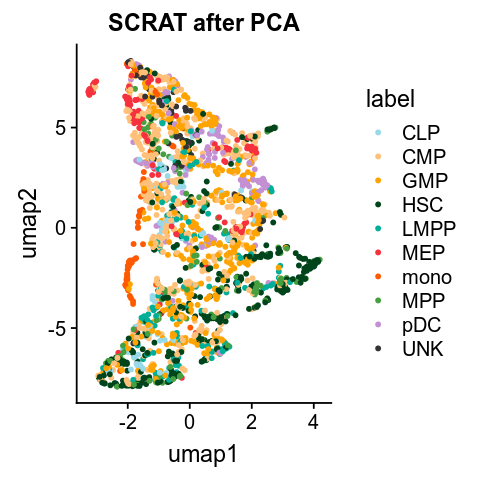

In [47]:
p_SCRAT2 <- plot_umap(df_umap_SCRAT2,labels = labels,colormap = colormap,title='SCRAT after PCA')
p_SCRAT2

In [48]:
dim(fm_SCRAT2)

[1]   10 2034

In [49]:
fm_SCRAT2_new = fm_SCRAT2[2:dim(fm_SCRAT2)[1],]
dim(fm_SCRAT2_new)

[1]    9 2034

In [50]:
df_umap_SCRAT2_new <- run_umap(fm_SCRAT2_new)

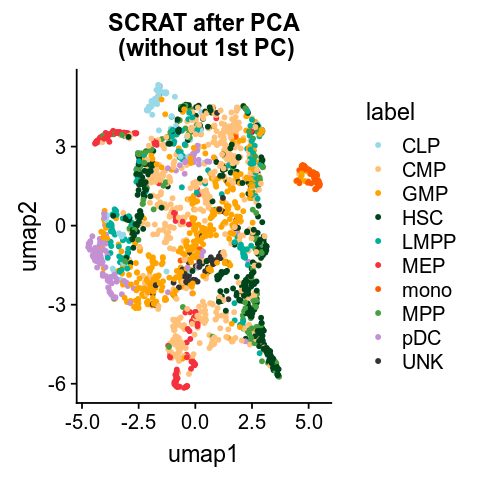

In [51]:
p_SCRAT2_new <- plot_umap(df_umap_SCRAT2_new,labels = labels,colormap = colormap,title='SCRAT after PCA\n (without 1st PC)')
p_SCRAT2_new

### BROCKMAN

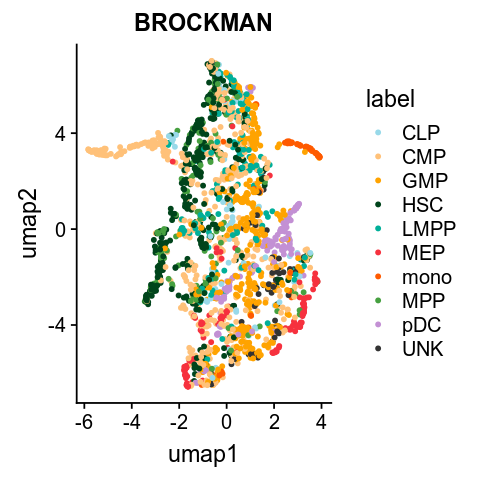

In [52]:
p_BROCKMAN <- plot_umap(df_umap_BROCKMAN,labels = labels,colormap = colormap,title='BROCKMAN')
p_BROCKMAN

In [53]:
dim(fm_BROCKMAN)

[1]   10 2034

In [54]:
fm_BROCKMAN_new = fm_BROCKMAN[2:dim(fm_BROCKMAN)[1],]
dim(fm_BROCKMAN_new)

[1]    9 2034

In [55]:
df_umap_BROCKMAN_new <- run_umap(fm_BROCKMAN_new)

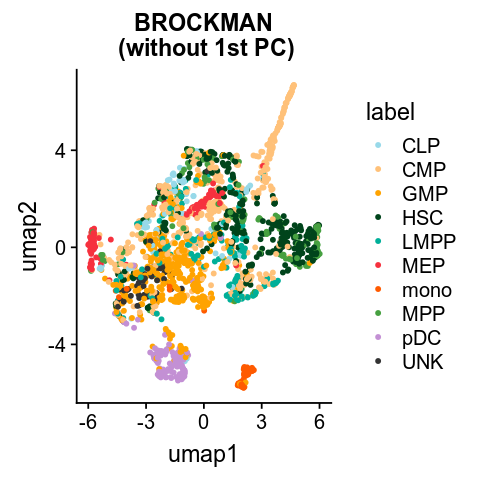

In [56]:
p_BROCKMAN_new <- plot_umap(df_umap_BROCKMAN_new,labels = labels,colormap = colormap,title='BROCKMAN\n (without 1st PC)')
p_BROCKMAN_new

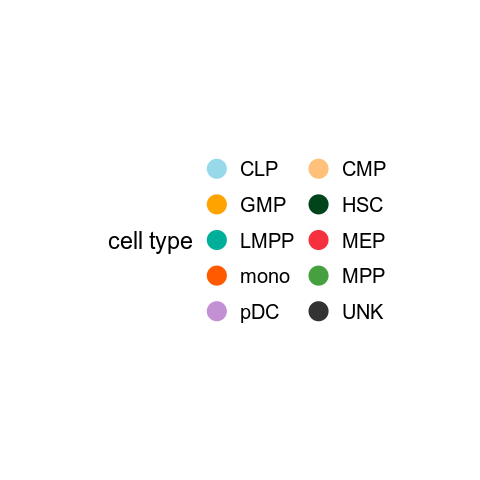

In [57]:
options(repr.plot.width=4, repr.plot.height=4)
leg <- cowplot::get_legend(p_Control + theme(legend.direction = "horizontal", legend.position = c(0.2,0.5)) + 
                           labs(color='cell type')+
                           guides(color=guide_legend(nrow=5,byrow=TRUE,override.aes = list(size=5))))

p_legend = as_ggplot(leg)
p_legend

In [6]:
# load('test_firstPC_buenrostro2018.RData')

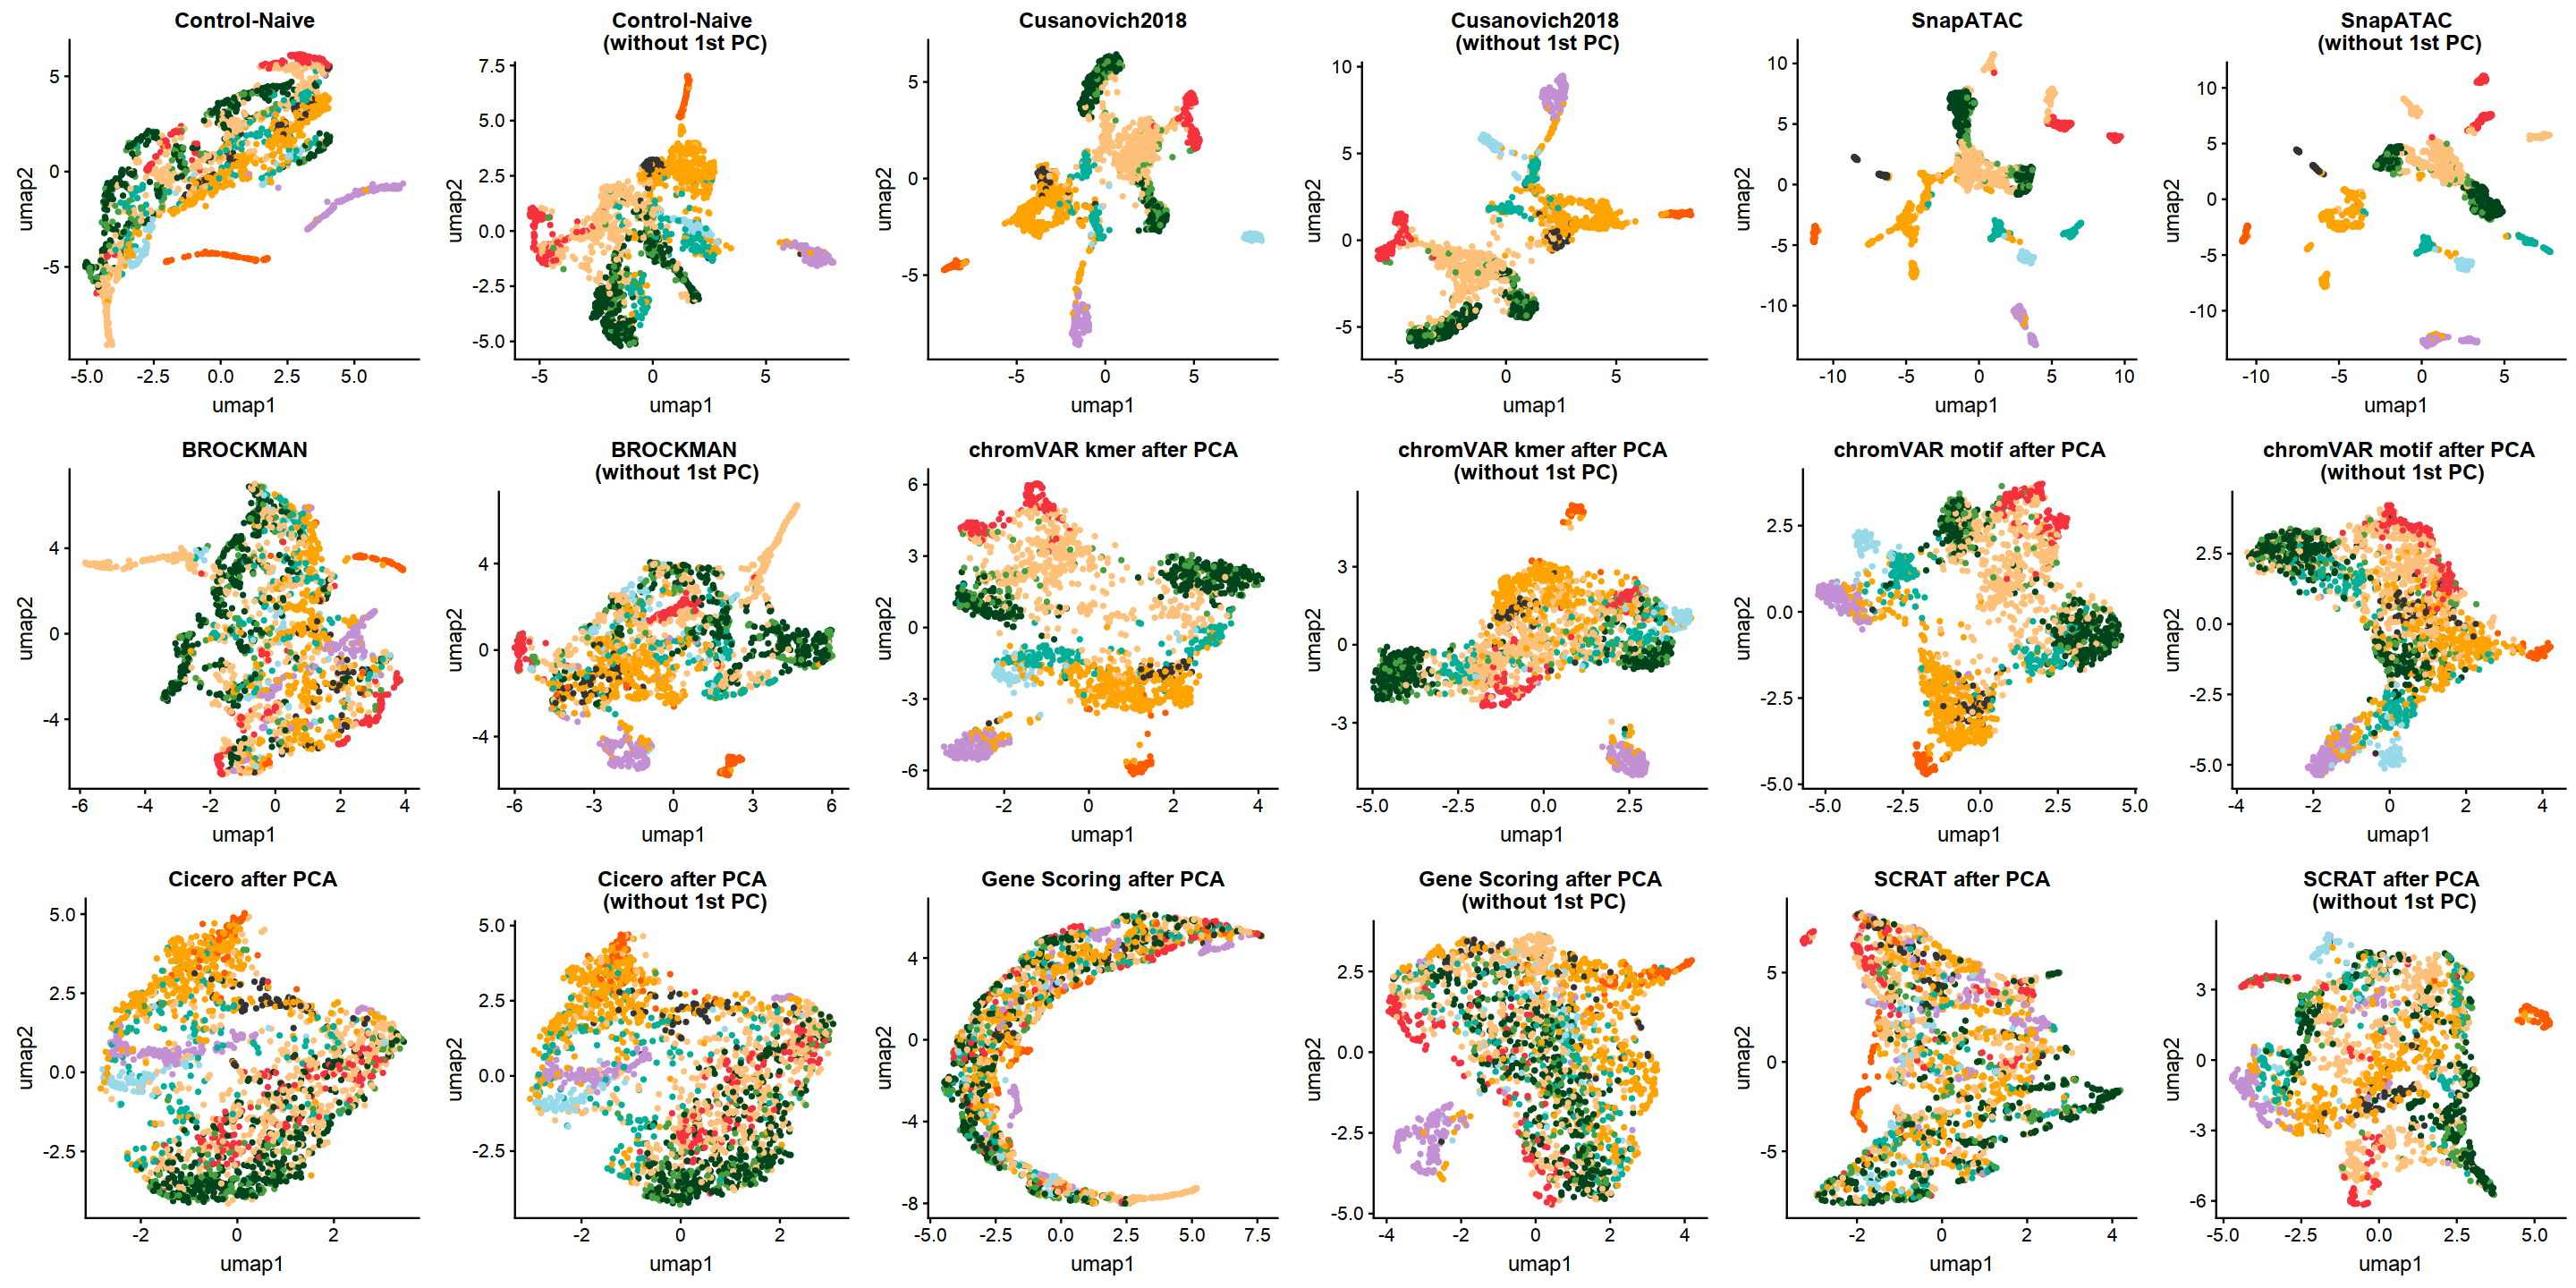

In [7]:
options(repr.plot.width=4*6, repr.plot.height=4*3)
p_group = cowplot::plot_grid(  p_Control+theme(legend.position = "none"),
                               p_Control_new+theme(legend.position = "none"),
                               p_Cusanovich2018+theme(legend.position = "none"),
                               p_Cusanovich2018_new+theme(legend.position = "none"),
                               p_SnapATAC+theme(legend.position = "none"),
                               p_SnapATAC_new+theme(legend.position = "none"),

                               p_BROCKMAN+theme(legend.position = "none"),
                               p_BROCKMAN_new+theme(legend.position = "none"),
                               p_chromVAR_kmers2+theme(legend.position = "none"),
                               p_chromVAR_kmers2_new+theme(legend.position = "none"),
                               p_chromVAR_motifs2+theme(legend.position = "none"),      
                               p_chromVAR_motifs2_new+theme(legend.position = "none"), 

                               p_Cicero2+theme(legend.position = "none"),
                               p_Cicero2_new+theme(legend.position = "none"),
                               p_GeneScoring2+theme(legend.position = "none"),
                               p_GeneScoring2_new+theme(legend.position = "none"),
                               p_SCRAT2+theme(legend.position = "none"),
                               p_SCRAT2_new+theme(legend.position = "none"),
                               labels = "",ncol = 6)
p_group

In [ ]:
cowplot::ggsave(p_group,filename = 'test_firstPC_buenrostro2018.pdf', width = 4*6, height = 4*3)

#### Save feature matrices and UMAP coordinates

In [60]:
saveRDS(df_umap_Control,paste0(path_umap,'df_umap_Control.rds'))
saveRDS(df_umap_Control_new,paste0(path_umap,'df_umap_Control_new.rds'))

saveRDS(df_umap_BROCKMAN,paste0(path_umap,'df_umap_BROCKMAN.rds'))
saveRDS(df_umap_BROCKMAN_new,paste0(path_umap,'df_umap_BROCKMAN_new.rds'))

saveRDS(df_umap_Cusanovich2018,paste0(path_umap,'df_umap_Cusanovich2018.rds'))
saveRDS(df_umap_Cusanovich2018_new,paste0(path_umap,'df_umap_Cusanovich2018_new.rds'))

saveRDS(df_umap_chromVAR_kmers2,paste0(path_umap,'df_umap_chromVAR_kmers2.rds'))
saveRDS(df_umap_chromVAR_kmers2_new,paste0(path_umap,'df_umap_chromVAR_kmers2_new.rds'))

saveRDS(df_umap_chromVAR_motifs2,paste0(path_umap,'df_umap_chromVAR_motifs2.rds'))
saveRDS(df_umap_chromVAR_motifs2_new,paste0(path_umap,'df_umap_chromVAR_motifs2_new.rds'))

saveRDS(df_umap_GeneScoring2,paste0(path_umap,'df_umap_GeneScoring2.rds'))
saveRDS(df_umap_GeneScoring2_new,paste0(path_umap,'df_umap_GeneScoring2_new.rds'))

saveRDS(df_umap_Cicero2,paste0(path_umap,'df_umap_Cicero2.rds'))
saveRDS(df_umap_Cicero2_new,paste0(path_umap,'df_umap_Cicero2_new.rds'))

saveRDS(df_umap_SnapATAC,paste0(path_umap,'df_umap_SnapATAC.rds'))
saveRDS(df_umap_SnapATAC_new,paste0(path_umap,'df_umap_SnapATAC_new.rds'))

saveRDS(df_umap_SCRAT2,paste0(path_umap,'df_umap_SCRAT2.rds'))
saveRDS(df_umap_SCRAT2_new,paste0(path_umap,'df_umap_SCRAT2_new.rds'))

In [61]:
saveRDS(fm_Control,paste0(path_fm,'fm_Control.rds'))
saveRDS(fm_Control_new,paste0(path_fm,'fm_Control_new.rds'))

saveRDS(fm_BROCKMAN,paste0(path_fm,'fm_BROCKMAN.rds'))
saveRDS(fm_BROCKMAN_new,paste0(path_fm,'fm_BROCKMAN_new.rds'))

saveRDS(fm_Cusanovich2018,paste0(path_fm,'fm_Cusanovich2018.rds'))
saveRDS(fm_Cusanovich2018_new,paste0(path_fm,'fm_Cusanovich2018_new.rds'))

saveRDS(fm_chromVAR_kmers2,paste0(path_fm,'fm_chromVAR_kmers2.rds'))
saveRDS(fm_chromVAR_kmers2_new,paste0(path_fm,'fm_chromVAR_kmers2_new.rds'))

saveRDS(fm_chromVAR_motifs2,paste0(path_fm,'fm_chromVAR_motifs2.rds'))
saveRDS(fm_chromVAR_motifs2_new,paste0(path_fm,'fm_chromVAR_motifs2_new.rds'))

saveRDS(fm_GeneScoring2,paste0(path_fm,'fm_GeneScoring2.rds'))
saveRDS(fm_GeneScoring2_new,paste0(path_fm,'fm_GeneScoring2_new.rds'))

saveRDS(fm_Cicero2,paste0(path_fm,'fm_Cicero2.rds'))
saveRDS(fm_Cicero2_new,paste0(path_fm,'fm_Cicero2_new.rds'))

saveRDS(fm_SnapATAC,paste0(path_fm,'fm_SnapATAC.rds'))
saveRDS(fm_SnapATAC_new,paste0(path_fm,'fm_SnapATAC_new.rds'))

saveRDS(fm_SCRAT2,paste0(path_fm,'fm_SCRAT2.rds'))
saveRDS(fm_SCRAT2_new,paste0(path_fm,'fm_SCRAT2_new.rds'))

In [62]:
save.image(file = 'test_firstPC_buenrostro2018.RData')